In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Data Augmentation
Lets add augmented data to our Dataset Before proceeding lets understand some of the datasets

## Augmentation methods

In [2]:
"""
    Adding White Noise.
"""

def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    

In [3]:
"""
    Random Shifting.
"""

def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)

In [4]:
"""
    Streching the Sound. Note that this expands the dataset slightly
"""

def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

In [5]:
"""
    Pitch Tuning.
"""

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [8]:
"""
    Random Value Change.
"""

def dyn_change(data):
    dyn_change = np.random.uniform(low=-0.5 ,high=3)  # default low = 1.5, high = 3
    return (data * dyn_change)

In [9]:
"""
    peed and Pitch Tuning.
"""

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [10]:
os.listdir('Data/genres_original')

['metal',
 'blues',
 'country',
 'reggae',
 'rock',
 'hiphop',
 'classical',
 'pop',
 'disco',
 'jazz']

In [11]:
Class = ['country',
 'jazz',
 'classical',
 'pop',
 'blues',
 'hiphop',
 'disco',
 'reggae',
 'rock',
 'metal']

In [12]:
Class.sort()

In [13]:
Class

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

# Load the dataset

In [14]:
ref = pd.DataFrame()

labels_list =[]
path_list = []

for i in Class:
    filepath = os.path.join('Data/genres_original',i)
    label  = i
    for audio_name in os.listdir(filepath):
        audiopath = os.path.join(filepath , audio_name)
        labels_list.append(label)
        path_list.append(audiopath)
    

In [15]:
ref["labels"] = labels_list
ref["path"] = path_list

In [16]:
ref.head(200)

,labels,path
0,blues,Data/genres_original/blues/blues.00011.wav
1,blues,Data/genres_original/blues/blues.00038.wav
2,blues,Data/genres_original/blues/blues.00045.wav
3,blues,Data/genres_original/blues/blues.00076.wav
4,blues,Data/genres_original/blues/blues.00012.wav
...,...,...
195,classical,Data/genres_original/classical/classical.00000...
196,classical,Data/genres_original/classical/classical.00020...
197,classical,Data/genres_original/classical/classical.00013...
198,classical,Data/genres_original/classical/classical.00052...


In [17]:
ref.shape

(1000, 2)

In [18]:
ref["path"][0]

'Data/genres_original/blues/blues.00011.wav'

# Feature Extraction

In [19]:
from tqdm import tqdm

In [20]:
def features(X, sample_rate) :
    mfccs_features = librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc =39)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [21]:
X, sample_rate = librosa.load(ref["path"][0], res_type='kaiser_fast')
        
#original data
stretched_data = stretch(X)
data = features(stretched_data, sample_rate)
print(data)

[-319.8637      116.84348       8.3179865    31.60435       1.7392108
   14.198795     -4.266875      8.528231      1.6613787     6.422541
   -4.233269     -3.2071006    -5.5471396    -6.9196305    -2.4725382
   -2.6797173    -3.0939765    -1.5509498     2.0506804    -4.6061883
   -5.387544     -3.4189782    -1.6891629    -6.312749     -6.700976
   -2.6229827     1.7228553    -1.7576638    -4.2560606    -2.5068488
   -1.7581352    -1.5971193    -1.5003239    -0.82076085   -2.6733434
   -2.4460673    -1.064068     -1.1356715    -1.4535843 ]


In [ ]:
df = pd.DataFrame(columns=['feature', "music_label"])

# loop feature extraction over the entire dataset
counter=0
for index,path in tqdm(enumerate(ref.path)):
    try:
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        
        #original data
        data = features(X,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        # add noise
        noised_data = noise(X) ;
        data = features(noised_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #shift data
        shifted_data = shift(X)
        data = features(shifted_data,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #stretch data
        stretched_data = stretch(X)
        data = features(stretched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1 
        
        # pitch
        pitched_data = pitch(X,sample_rate)
        data = features(pitched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #random change 
        random_changed_data = dyn_change(X)
        data = features(random_changed_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #speed and Pitch Tuning.
        newX = speedNpitch(X)
        data = features(newX, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
                
    except :
        pass

# Check a few records to make sure its processed successfully
print(len(df))
df

530it [20:41,  1.99s/it]

In [86]:
import pickle
pickle.dump(df, open("augmented_data_mfccs", "wb"))

In [2]:
import pickle
df = pickle.load(open("augmented_data_mfccs", "rb"))

In [3]:
final_df = pd.DataFrame()
final_df = pd.concat([final_df,pd.DataFrame(df["music_label"]),pd.DataFrame(df['feature'].values.tolist())],axis=1)


In [4]:
final_df.head()

,music_label,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,blues,-287.923737,124.018753,5.469893,33.657410,1.095497,14.705335,-4.877008,8.670525,0.785405,...,-3.332774,-2.249990,-1.918967,-1.869811,-1.351443,-2.922709,-2.683403,-1.294172,-1.406098,-1.289762
1,blues,-119.024773,26.858641,19.048770,13.170257,8.669902,6.497419,4.536497,3.476875,2.788489,...,-1.835771,-1.375615,-1.128790,-1.267999,-1.163204,-1.250469,-1.045684,-0.773457,-0.738801,-0.531399
2,blues,-287.917511,123.998650,5.489083,33.709064,1.084248,14.766724,-4.874308,8.676586,0.779761,...,-3.318143,-2.234523,-1.902917,-1.873781,-1.352071,-2.930924,-2.681502,-1.305556,-1.398083,-1.297149
3,blues,-319.863708,116.843483,8.317986,31.604349,1.739211,14.198795,-4.266875,8.528231,1.661379,...,-2.506849,-1.758135,-1.597119,-1.500324,-0.820761,-2.673343,-2.446067,-1.064068,-1.135671,-1.453584
4,blues,-311.074136,110.342307,9.692371,24.935264,0.911718,9.470779,-2.748157,8.888032,-1.804883,...,-2.064354,-3.127208,-1.809553,-1.779080,0.276796,1.250107,-0.338174,-1.104776,-1.742530,-4.134837


In [5]:
# replace NA with 0
final_df=final_df.fillna(0)
print(final_df.shape)
final_df[:5]


(6993, 40)


,music_label,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,blues,-287.923737,124.018753,5.469893,33.657410,1.095497,14.705335,-4.877008,8.670525,0.785405,...,-3.332774,-2.249990,-1.918967,-1.869811,-1.351443,-2.922709,-2.683403,-1.294172,-1.406098,-1.289762
1,blues,-119.024773,26.858641,19.048770,13.170257,8.669902,6.497419,4.536497,3.476875,2.788489,...,-1.835771,-1.375615,-1.128790,-1.267999,-1.163204,-1.250469,-1.045684,-0.773457,-0.738801,-0.531399
2,blues,-287.917511,123.998650,5.489083,33.709064,1.084248,14.766724,-4.874308,8.676586,0.779761,...,-3.318143,-2.234523,-1.902917,-1.873781,-1.352071,-2.930924,-2.681502,-1.305556,-1.398083,-1.297149
3,blues,-319.863708,116.843483,8.317986,31.604349,1.739211,14.198795,-4.266875,8.528231,1.661379,...,-2.506849,-1.758135,-1.597119,-1.500324,-0.820761,-2.673343,-2.446067,-1.064068,-1.135671,-1.453584
4,blues,-311.074136,110.342307,9.692371,24.935264,0.911718,9.470779,-2.748157,8.888032,-1.804883,...,-2.064354,-3.127208,-1.809553,-1.779080,0.276796,1.250107,-0.338174,-1.104776,-1.742530,-4.134837


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['music_label'],axis=1)
                                                    , df.music_label
                                                    , test_size=0.2
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
3161,-153.631209,54.728210,7.327468,28.778873,14.455557,19.034136,1.607067,12.116240,1.295589,10.416765,...,4.879117,-2.791361,1.025867,-4.996559,-0.119042,-4.338065,0.149661,-1.407545,-0.341267,-5.305658
3961,-295.749634,17.633789,11.041233,15.331118,0.707521,2.314151,-0.323374,1.917517,-1.220152,-1.743622,...,-8.772393,-0.165742,-1.393898,-3.050306,-0.220017,-2.929310,-3.992458,0.955322,-2.300848,-2.459456
3248,-114.013184,110.141655,17.895763,37.946213,27.990702,1.409508,15.558240,1.416771,7.350121,-3.328758,...,0.445523,-0.799791,-3.270779,-2.892370,-3.034730,-4.360257,-3.785025,-4.210545,-3.329576,-4.010273
149,-30.003922,103.721565,-19.702337,56.405865,-12.674723,20.182302,-17.314663,16.292503,-18.415098,8.920375,...,0.959804,-1.261317,0.829062,-1.760993,0.424015,1.535374,-2.733870,-0.981995,-0.688257,0.773562
4667,102.415703,71.188530,-22.356430,60.283909,-18.555540,27.631037,-12.416348,16.956554,-8.735030,17.874517,...,-2.773022,-0.840817,-0.988296,-3.076647,-3.681731,-2.641047,-3.498552,-3.981525,-1.897902,-0.668273
3869,-127.217369,174.379013,-19.723118,47.348381,-1.943280,6.657072,-1.088485,-5.514930,-13.738750,-3.710453,...,-1.418715,-2.419217,0.318602,2.662066,3.950414,1.012897,0.310657,0.798950,0.503115,-2.015257
453,-501.665375,72.082497,-7.753569,49.242702,-32.715286,21.595116,-27.360632,14.991588,-10.249062,12.419812,...,-8.420363,-2.047406,-2.885376,-3.088722,-2.104822,-2.716363,-4.231414,-5.474849,-1.858040,0.372894
3282,-195.065094,62.608288,-9.721052,25.520386,-3.053842,11.547413,-0.859861,9.634277,0.831613,3.857183,...,0.600307,-2.407020,-2.794544,-2.494597,0.409540,0.900051,1.409390,-0.863995,-5.643343,-4.616438
1786,-158.796689,95.959134,21.450940,42.811765,10.512532,17.075813,1.583922,8.916975,-6.239207,4.801858,...,4.440491,0.182580,-4.369256,-0.352467,-1.470487,-0.790809,-0.690152,-0.758338,0.154359,-4.407047
2716,-133.819321,93.490356,-24.230862,61.447289,-22.856272,30.987030,-14.966417,20.237169,-9.300377,15.792407,...,-4.594030,-5.492161,-2.938725,-0.464679,0.919730,0.194842,-0.974886,-1.625942,-4.302835,-3.814112


In [8]:
# # Lets do data normalization
# #Here we are using z-score normalization technique
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# # Check the dataset now 
# X_train[150:160]

In [9]:
from keras.utils import np_utils, to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Label encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'mgc_label_encoder'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(5594, 39)
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [11]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5594, 39, 1)

In [12]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


In [19]:
model = Sequential()
model.add(Conv1D(256, 4, padding='same',input_shape=(X_train.shape[1],1))) 
# X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(128, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(10)) # Target class number
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.0001)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 39, 256)           1280      
_________________________________________________________________
activation_14 (Activation)   (None, 39, 256)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 39, 256)           262400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 39, 256)           1024      
_________________________________________________________________
activation_15 (Activation)   (None, 39, 256)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 256)           

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
175/175 [==============================] - 8s 36ms/step - loss: 2.3600 - accuracy: 0.1318 - val_loss: 2.0485 - val_accuracy: 0.2659
Epoch 2/40
175/175 [==============================] - 5s 30ms/step - loss: 2.0396 - accuracy: 0.2639 - val_loss: 1.8635 - val_accuracy: 0.3746
Epoch 3/40
175/175 [==============================] - 5s 31ms/step - loss: 1.8865 - accuracy: 0.3126 - val_loss: 1.7592 - val_accuracy: 0.4224
Epoch 4/40
175/175 [==============================] - 5s 30ms/step - loss: 1.7843 - accuracy: 0.3569 - val_loss: 1.6796 - val_accuracy: 0.4761
Epoch 5/40
175/175 [==============================] - 5s 31ms/step - loss: 1.7059 - accuracy: 0.3983 - val_loss: 1.5961 - val_accuracy: 0.4975
Epoch 6/40
175/175 [==============================] - 5s 31ms/step - loss: 1.6347 - accuracy: 0.4216 - val_loss: 1.5130 - val_accuracy: 0.5175
Epoch 7/40
175/175 [==============================] - 5s 31ms/step - loss: 1.5962 - accuracy: 0.4384 - val_loss: 1.4590 - val_accuracy: 0.5447

In [21]:
model.save("MGC_Models/mgc_mfccs.h5") 

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
score
print("Loss : {}  \nAccuracy : {} ".format(score[0], score[1]))

Loss : 0.7296628355979919  
Accuracy : 0.7755539417266846 


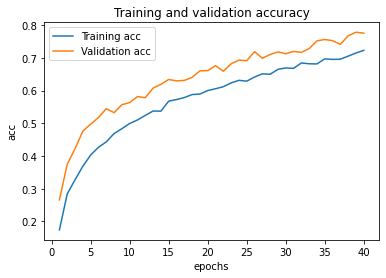

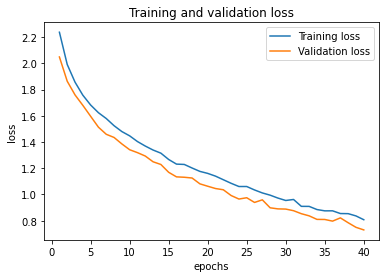

In [23]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()